# Image Captioning

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms

sys.path.append('/home/leeping/Documents/Repositories/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN

%load_ext autoreload
%autoreload 2

## 1. Training the Model

I referred to this paper for the architecture: *Show and Tell: A Neural Image Caption Generator* (https://arxiv.org/pdf/1411.4555.pdf).

Some hyperparameters such as `vocab_threshold=5`, `embed_size=512`, and `hidden_size=512` are chosen as these were used in the referenced paper as well.

In [2]:
batch_size = 64         
# vocab_threshold: number of times that a word must appear in the training captions before it is used as part of the vocabulary.
# Words that have fewer than vocab_threshold occurrences in the training captions are considered unknown words.
vocab_threshold = 5        
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# default input shape for Resnet is (224, 224, 3)
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
# For the decoder, the weights need to be trained from scratch
# For the encoder, we are using a pretrained model, and only the weights for the new embed layer need training
params = list(decoder.parameters()) + list(encoder.embed.parameters())

optimizer = torch.optim.Adam(params, lr=0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


  0%|          | 0/414113 [00:00<?, ?it/s]

Done (t=0.46s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:34<00:00, 12149.50it/s]


In [3]:
for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
                
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))


Epoch [1/3], Step [100/6471], Loss: 4.0348, Perplexity: 56.5316
Epoch [1/3], Step [200/6471], Loss: 3.9882, Perplexity: 53.95827
Epoch [1/3], Step [300/6471], Loss: 3.1317, Perplexity: 22.9125
Epoch [1/3], Step [400/6471], Loss: 3.0635, Perplexity: 21.4030
Epoch [1/3], Step [500/6471], Loss: 2.8087, Perplexity: 16.5881
Epoch [1/3], Step [600/6471], Loss: 3.2107, Perplexity: 24.7963
Epoch [1/3], Step [700/6471], Loss: 3.1061, Perplexity: 22.3338
Epoch [1/3], Step [800/6471], Loss: 2.9191, Perplexity: 18.5242
Epoch [1/3], Step [900/6471], Loss: 2.8205, Perplexity: 16.7849
Epoch [1/3], Step [1000/6471], Loss: 2.7824, Perplexity: 16.1570
Epoch [1/3], Step [1100/6471], Loss: 3.1342, Perplexity: 22.9708
Epoch [1/3], Step [1200/6471], Loss: 2.7797, Perplexity: 16.1141
Epoch [1/3], Step [1300/6471], Loss: 2.5732, Perplexity: 13.1081
Epoch [1/3], Step [1400/6471], Loss: 2.5513, Perplexity: 12.8238
Epoch [1/3], Step [1500/6471], Loss: 2.8462, Perplexity: 17.2228
Epoch [1/3], Step [1600/6471], Lo

Epoch [2/3], Step [6300/6471], Loss: 2.0697, Perplexity: 7.92266
Epoch [2/3], Step [6400/6471], Loss: 2.0531, Perplexity: 7.79172
Epoch [3/3], Step [100/6471], Loss: 1.9897, Perplexity: 7.313141
Epoch [3/3], Step [200/6471], Loss: 2.4233, Perplexity: 11.2835
Epoch [3/3], Step [300/6471], Loss: 2.1650, Perplexity: 8.71485
Epoch [3/3], Step [400/6471], Loss: 2.0190, Perplexity: 7.53081
Epoch [3/3], Step [500/6471], Loss: 2.1516, Perplexity: 8.59884
Epoch [3/3], Step [600/6471], Loss: 2.1247, Perplexity: 8.37005
Epoch [3/3], Step [700/6471], Loss: 2.1353, Perplexity: 8.45920
Epoch [3/3], Step [800/6471], Loss: 2.1850, Perplexity: 8.89042
Epoch [3/3], Step [900/6471], Loss: 1.9227, Perplexity: 6.83955
Epoch [3/3], Step [1000/6471], Loss: 1.9400, Perplexity: 6.9588
Epoch [3/3], Step [1100/6471], Loss: 1.8973, Perplexity: 6.66807
Epoch [3/3], Step [1200/6471], Loss: 1.9942, Perplexity: 7.34653
Epoch [3/3], Step [1300/6471], Loss: 2.1002, Perplexity: 8.16740
Epoch [3/3], Step [1400/6471], Los

## 2. Generating Captions for Images

In [4]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

data_loader = get_loader(transform=transform_test,    
                         mode='test')

# Use the pickled model that's been trained for 3 epochs
encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

embed_size = 512
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

Vocabulary successfully loaded from vocab.pkl file!


DecoderRNN(
  (word_embeddings): Embedding(8856, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8856, bias=True)
)

In [5]:
def clean_sentence(output):
    sentence = ""
    for idx in output:
        word = data_loader.dataset.vocab.idx2word[idx]
        if (word == data_loader.dataset.vocab.start_word):
            continue
        elif (word == data_loader.dataset.vocab.end_word):
            break
        else:
            sentence = sentence + " " + word
    return sentence

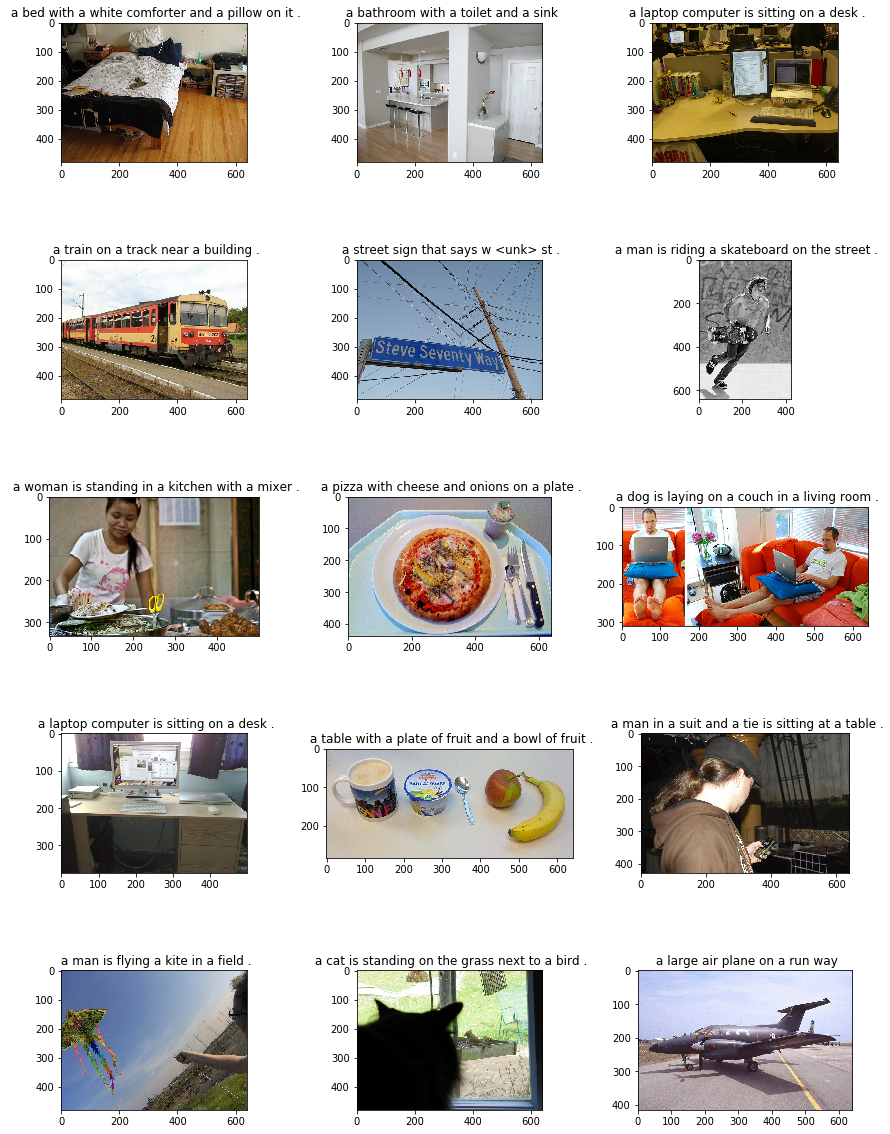

In [19]:
fig, axs = plt.subplots(5, 3, figsize=(15,20))
plt.subplots_adjust(hspace=0.7)

for row in range(5):
    for col in range(3):
        orig_image, image = next(iter(data_loader))
        image = image.to(device)
        # from torch.Size([1,512]) to torch.Size([1,1,512])
        features = encoder(image).unsqueeze(1)
        output = decoder.sample(features)    
        sentence = clean_sentence(output)
        axs[row, col].imshow(np.squeeze(orig_image))
        axs[row, col].set_title(sentence)

As can be seen from the generated captions above, the model gets it right about half the time. There's room for improvement - perhaps it can be trained for more epochs. It took about 5 hours to train the model on my Nvidia RTX 2070 GPU for 3 epochs.